In [28]:
#basics
import os
from path import Path
import numpy as np
import pandas as pd
#feature extraction
import librosa.display
import librosa.feature
#preProcessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
#data visualization
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
#model building
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential
#evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

## Loading the data

In [3]:
#setting directories
main_dir = 'split/'

train_path = os.path.join(main_dir,'train')
test_path = os.path.join(main_dir,'test')
val_path = os.path.join(main_dir,'val')

#setting class directories 
target_folders = os.listdir(test_path)[0:7]
#remove .DS_Store from folders
target_folders.remove('.DS_Store')

file_paths = []

for i in range(len(target_folders)):
  target_path = os.path.join(test_path,target_folders[i])
  files = os.listdir(target_path)[0:5]
  for file in files:
    file_path = os.path.join(target_path,file)
    file_paths.append(file_path)

split/test/crashes
['VEH4 Crash 16.jpg', 'KSHMR_Crash_03.jpg', 'VEH2 Crash - 14.jpg', 'VEH2 Crash - 29.jpg', 'VEH4 Crash 04.jpg']
split/test/hihats
['VMH1 Open Hats 044.jpg', 'VMH1 Open Hats 093.jpg', 'VEH4 Hihat Closed 012.jpg', 'DPHE Closed Hat - 094.jpg', 'DPHE Closed Hat - 137.jpg']
split/test/percussion
['VMH1 Minimal Perc 324.jpg', 'VES1 Percussion 246.jpg', 'VMH1 Minimal Perc 286.jpg', 'VMH1 Minimal Perc 053.jpg', 'VEE Percussion 082.jpg']
split/test/toms
['VEH1 Tom - 16.jpg', 'VEH1 Tom - 03.jpg', 'DPHE Tom - 028.jpg', 'VEH1 Tom - 13.jpg', 'DPHE Tom - 101.jpg']
split/test/claps
['VEE2 Clap 052.jpg', 'VEE2 Clap 085.jpg', 'VEH3 Claps 083.jpg', 'VES1 Claps 125.jpg', 'VEE Clap 147.jpg']
split/test/snares
['VEH3 Snares 119.jpg', 'VES1 Snare 100.jpg', 'VEH3 Snares 131.jpg', 'DPHE Snare - 090.jpg', 'VEH3 Snares 044.jpg']


In [4]:
target_folders

['crashes', 'hihats', 'percussion', 'toms', 'claps', 'snares']

In [5]:
import os
MAIN_DIR = 'split/'
NUM_CLASSES = 7


def get_file_paths(main_dir, num_classes):
    train_path = os.path.join(main_dir,'train')
    test_path = os.path.join(main_dir,'test')
    val_path = os.path.join(main_dir,'val')

    #setting class directories 
    target_folders = os.listdir(test_path)[0:num_classes]
    #remove .DS_Store from folders
    target_folders.remove('.DS_Store')

    file_paths = []

    for i in range(len(target_folders)):
      target_path = os.path.join(test_path,target_folders[i])
      files = os.listdir(target_path)
      for file in files:
        file_path = os.path.join(target_path,file)
        file_paths.append(file_path)

    return file_paths

In [6]:
file_paths = get_file_paths(MAIN_DIR, NUM_CLASSES)

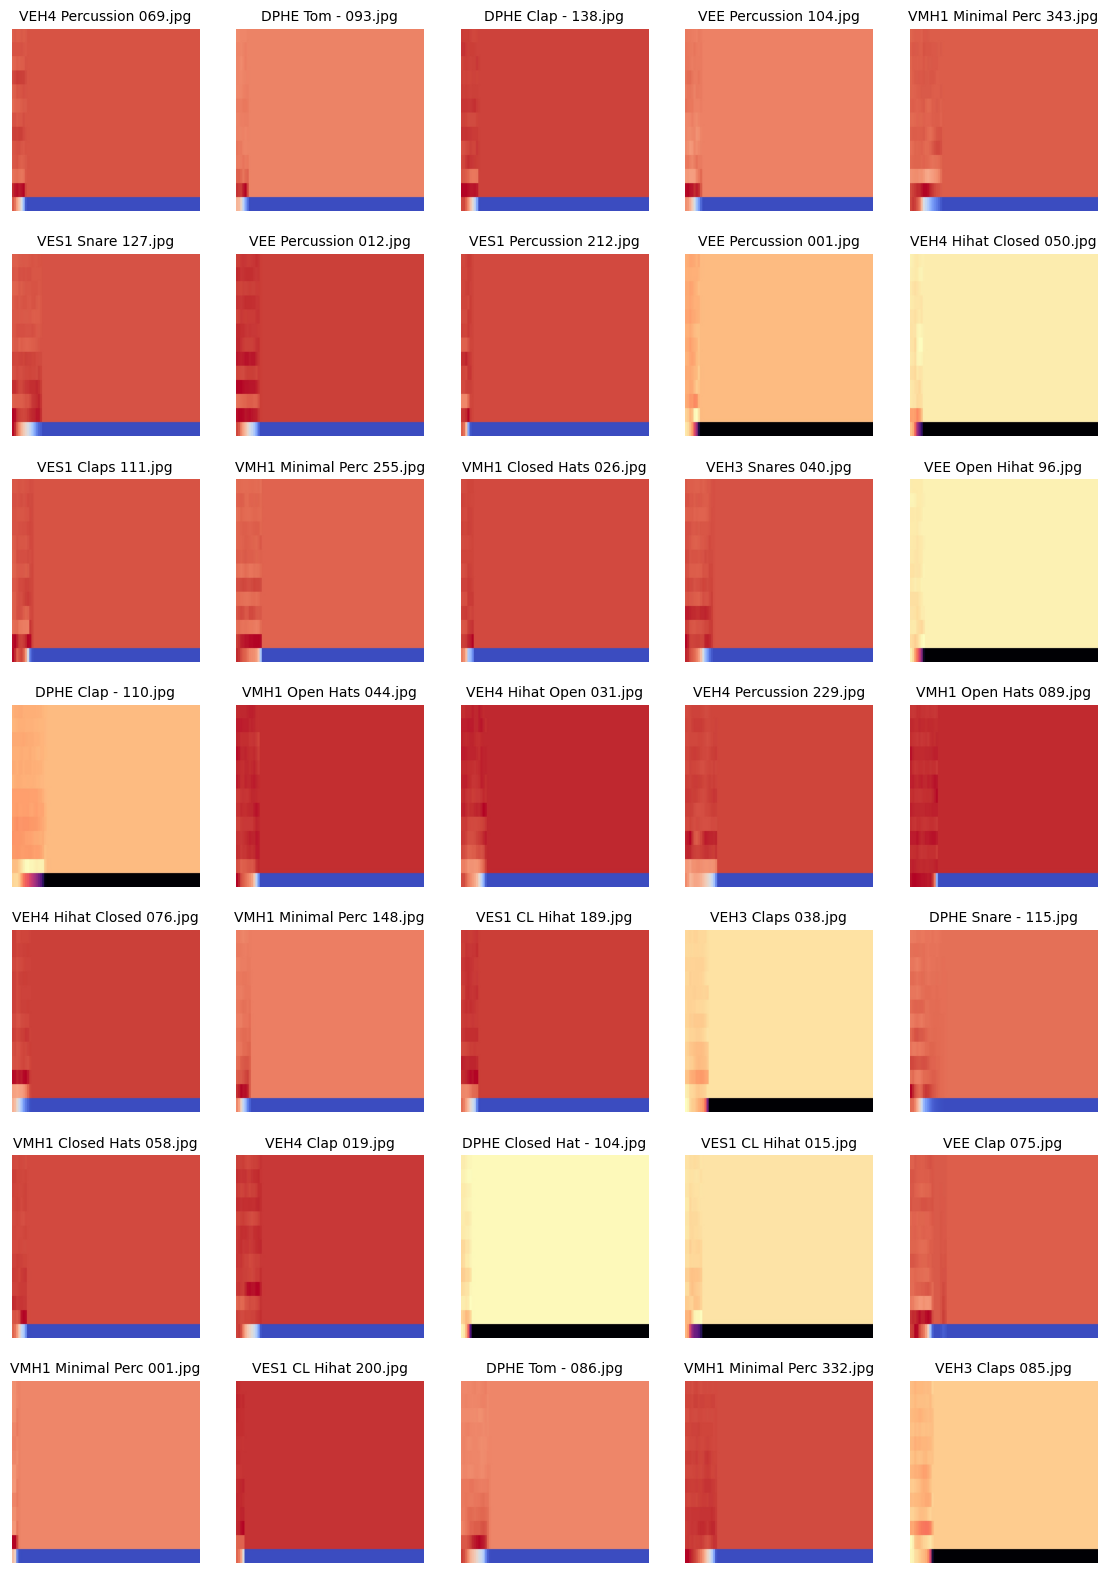

In [7]:
import matplotlib.image as mpimg
import random
#set the number of columns and rows
rows = 7
cols = 5
#set the figure size
fig = plt.gcf()
fig.set_size_inches(14,20)
#plotting 35 random samples
plot_samples = random.sample(file_paths, 35)

for i, img_path in enumerate(plot_samples):
  name = img_path.split('/')[-1]
  sp = plt.subplot(rows,cols,i+1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  sp.set_title(name,fontsize=10)
  plt.imshow(img,cmap='gray')

#save figure
plt.savefig('Spectograms',dpi=600,bbox_inches='tight',pad_inches=0)
plt.show()

In [8]:

train_gen = ImageDataGenerator(
    rescale= 1./255
)
test_gen = ImageDataGenerator(
    rescale= 1./255
)
val_gen = ImageDataGenerator(
    rescale= 1./255
)

train_generator = train_gen.flow_from_directory(
    train_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical')

validation_generator = train_gen.flow_from_directory(
    val_path,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical')

test_generator = test_gen.flow_from_directory(
    test_path,
    target_size=(150,150),
    shuffle = False,
    class_mode = 'categorical'
)

Found 5947 images belonging to 7 classes.
Found 741 images belonging to 7 classes.
Found 750 images belonging to 7 classes.


In [9]:
class DrumClassifier:
    def __init__(self, input_shape, num_classes, Conv2D_params, Dense_params,
                 activation='relu', kernel_size = (3,3), strides=(1, 1), pool_size = (2,2),
                 padding='same', optimizer='adam', dropout = 0.5,
                 loss='categorical_crossentropy', metrics=['acc']):

        self.input_shape = input_shape
        self.model = Sequential()
        #model built
        self.num_classes = num_classes
        self.Conv2D_params = Conv2D_params
        self.Dense_params = Dense_params
        self.activation = activation
        self.kernel_size = kernel_size
        self.strides = strides
        self.pool_size = pool_size
        self.padding = padding
        self.optimizer = optimizer
        self.dropout = dropout
        self.loss = loss
        self.metrics = metrics

    def add_Conv2D_layer(self, filters, kernel_size, activation=None, strides=None, padding=None):
        if activation is None:
            activation = self.activation
        if strides is None:
            strides = self.strides
        if padding is None:
            padding = self.padding
        self.model.add(Conv2D(filters, kernel_size, activation=activation, strides=strides, padding=padding))

    def add_MaxPool2D_layer(self, pool_size):
        self.model.add(MaxPool2D(pool_size))

    def add_Dropout_layer(self, rate):
        self.model.add(Dropout(rate))

    def add_Flatten_layer(self):
        self.model.add(Flatten())

    def add_Dense_layer(self, units, activation=None):
        if activation is None:
            activation = self.activation
        self.model.add(Dense(units, activation=activation))

    def compile_model(self, optimizer=None, loss=None, metrics=None):
        if optimizer is None:
            optimizer = self.optimizer
        if loss is None:
            loss = self.loss
        if metrics is None:
            metrics = self.metrics
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def build_model(self):
        self.model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=self.input_shape))
        for i in range(1, len(self.Conv2D_params)):
            self.add_Conv2D_layer(self.Conv2D_params[i],self.kernel_size)
        self.add_MaxPool2D_layer(self.pool_size)
        self.add_Dropout_layer(self.dropout)
        self.add_Flatten_layer()
        for units in self.Dense_params:
            self.add_Dense_layer(units)
            self.add_Dropout_layer(self.dropout)
        self.add_Dense_layer(self.num_classes, activation='softmax')
        self.compile_model()
        
    def train_model(self, training_data, validation_data, epochs):
        history = self.model.fit(training_data, epochs = epochs, validation_data = validation_data)
        return history


In [10]:
INPUT_SHAPE = train_generator.image_shape
CLASSES = 7
CONV2D_PARAMS = [16, 32]
DENSE_PARAMS = [128, 64]

drum_classifier = DrumClassifier(INPUT_SHAPE, CLASSES, CONV2D_PARAMS, DENSE_PARAMS)
drum_classifier.build_model()
drum_classifier.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 flatten (Flatten)           (None, 180000)            0         
                                                                 
 dense (Dense)               (None, 128)               23040128  
                                                        

In [11]:
history = drum_classifier.train_model(
                    training_data = train_generator,
                    epochs = 10,
                    validation_data=validation_generator
                    )

Epoch 1/10


2023-02-13 17:28:39.851499: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


186/186 [==============================] - 38s 200ms/step - loss: 1.7920 - acc: 0.3439 - val_loss: 1.2315 - val_acc: 0.5331
Epoch 2/10
186/186 [==============================] - 36s 193ms/step - loss: 1.2993 - acc: 0.4895 - val_loss: 1.0435 - val_acc: 0.5843
Epoch 3/10
186/186 [==============================] - 37s 198ms/step - loss: 1.1573 - acc: 0.5438 - val_loss: 0.9198 - val_acc: 0.6464
Epoch 4/10
186/186 [==============================] - 36s 193ms/step - loss: 1.0475 - acc: 0.6006 - val_loss: 0.8109 - val_acc: 0.7099
Epoch 5/10
186/186 [==============================] - 36s 195ms/step - loss: 0.9700 - acc: 0.6331 - val_loss: 0.7805 - val_acc: 0.7409
Epoch 6/10
186/186 [==============================] - 37s 200ms/step - loss: 0.9427 - acc: 0.6494 - val_loss: 0.7682 - val_acc: 0.7179
Epoch 7/10
186/186 [==============================] - 38s 202ms/step - loss: 0.9162 - acc: 0.6600 - val_loss: 0.7329 - val_acc: 0.7422
Epoch 8/10
186/186 [==============================] - 36s 194ms/st

In [12]:
# get the test acuarcy and loss
test_loss, test_acc = drum_classifier.model.evaluate(test_generator)
print('test loss:{} test acc:{}'.format(test_loss,test_acc))

24/24 [==============================] - 2s 64ms/step - loss: 0.5949 - acc: 0.7933
test loss:0.5948642492294312 test acc:0.7933333516120911


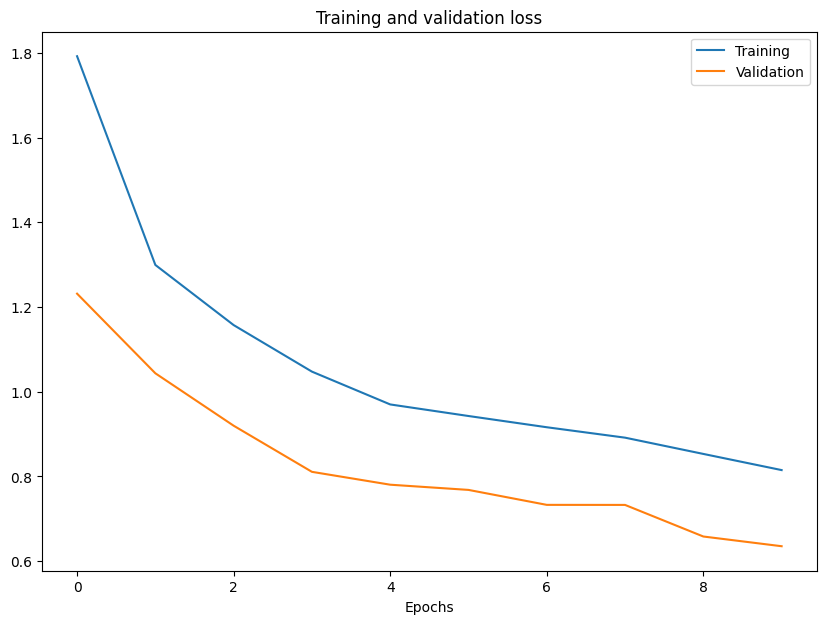

In [13]:
#plot graph between training and validation loss
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.savefig('Loss',dpi=600)
plt.show()

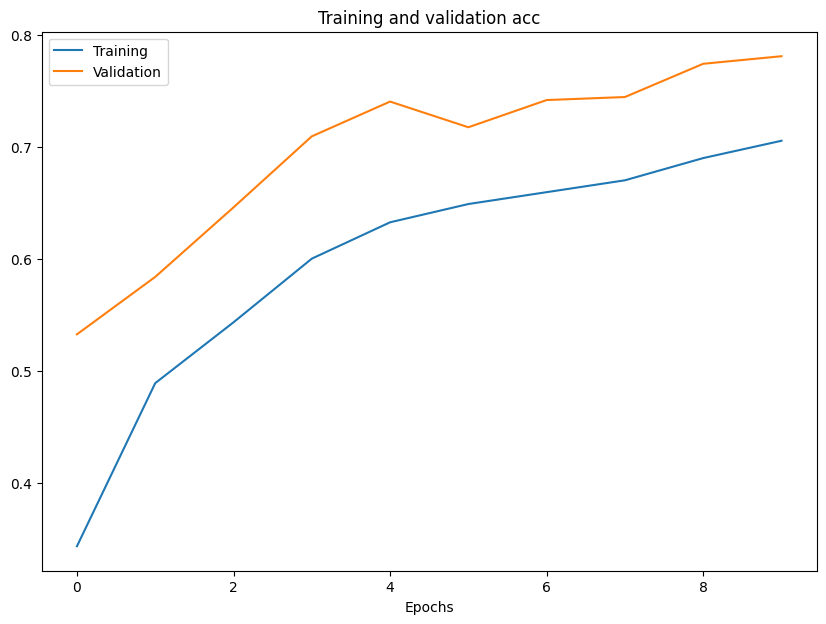

In [14]:
#plot graph between training and validation loss
plt.figure(figsize=(10,7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training','Validation'])
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.savefig('Accuracy',dpi=600)
plt.show()

In [27]:
predictions = drum_classifier.model.predict(test_generator)
predicted_classes = [np.argmax(prediction) for prediction in predictions]

#generating confusion matrix
#confusion matrix
cm = confusion_matrix(test_generator.classes, predicted_classes,labels=[0,1,2,3,4,5,6],normalize='true')

target_names = ['claps', 'crashes', 'hihats', 'kicks', 'percussion', 'snares', 'toms']
print('Confusion Matrix')
print(classification_report(test_generator.classes, predicted_classes, target_names=target_names))


24/24 [==============================] - 2s 72ms/step


In [25]:
labels = test_generator.class_indices.keys()
labels = np.asarray(labels)

df_cm = pd.DataFrame(cm, index=['claps', 'crashes', 'hihats', 'kicks', 'percussion', 'snares', 'toms'],
                     columns=['claps', 'crashes', 'hihats', 'kicks', 'percussion', 'snares', 'toms'])
plt.figure(figsize=(10,7))
sn.set(font_scale=1.0) # for label size

ax = sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}) # font size
ax.set(xlabel='Predicted Classes',ylabel='True Classes',title='Confusion Matrix')
#sn.heatmap()
plt.savefig('Confusion Matrix',dpi=600)
plt.show()